In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 18.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 18.0.0 which is incompatible.


In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1: Load tools


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Loading Dataset, Preprocessing, Tokenization, XLNET Fine Tuning

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("glue", "mrpc")

# Load the tokenizer and model (For XLNet)
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

# Ensure all tensors are contiguous
def make_contiguous(model):
    for param in model.parameters():
        if not param.is_contiguous():
            param.data = param.data.contiguous()

make_contiguous(model)

# Preprocess function for tokenizing the data
def preprocess_function(examples):
    # Tokenize sentence1 and sentence2
    model_inputs = tokenizer(examples['sentence1'], examples['sentence2'], truncation=True, padding=True)

    # Add labels to the tokenized inputs
    model_inputs['labels'] = examples['label']

    return model_inputs

# Apply the preprocess function to the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    evaluation_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The model to train
    args=training_args,                  # Training arguments
    train_dataset=encoded_dataset['train'],  # Training dataset
    eval_dataset=encoded_dataset['validation'],  # Evaluation dataset
    tokenizer=tokenizer,                  # Tokenizer
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation Results:")
print(results)



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.572800,0.562735
2,0.531700,0.537727
3,0.402800,0.363307
4,0.344700,0.393448
5,0.159800,0.410273


Evaluation Results:
{'eval_loss': 0.36330658197402954, 'eval_runtime': 3.2652, 'eval_samples_per_second': 124.953, 'eval_steps_per_second': 7.963, 'epoch': 5.0}


# Step 3: Model Evaluation, Classification Report, Confusion matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       129
           1       0.93      0.84      0.88       279

    accuracy                           0.85       408
   macro avg       0.82      0.85      0.83       408
weighted avg       0.86      0.85      0.85       408



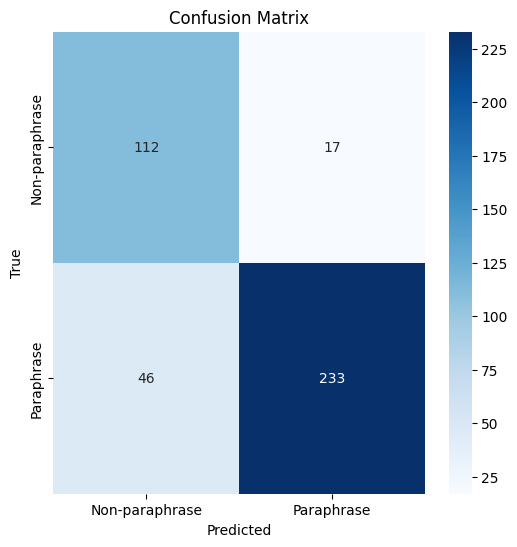

In [7]:
# Make predictions on the validation set
import numpy as np
predictions, true_labels, _ = trainer.predict(encoded_dataset['validation'])

# Convert logits to predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-paraphrase", "Paraphrase"], yticklabels=["Non-paraphrase", "Paraphrase"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Step 4: Save Tuned and Trained Model And Tokenizer

In [8]:
from transformers import XLNetTokenizer, XLNetForSequenceClassification

# Assuming model and tokenizer are already defined and trained
save_directory = "/content/drive/MyDrive/paraphrase_xlnet_model"

# Save the model and tokenizer to Google Drive
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)



('/content/drive/MyDrive/paraphrase_xlnet_model/tokenizer_config.json',
 '/content/drive/MyDrive/paraphrase_xlnet_model/special_tokens_map.json',
 '/content/drive/MyDrive/paraphrase_xlnet_model/spiece.model',
 '/content/drive/MyDrive/paraphrase_xlnet_model/added_tokens.json',
 '/content/drive/MyDrive/paraphrase_xlnet_model/tokenizer.json')

# Step 6: Inference (Classification Syste Real Time)

In [9]:
import torch

# Inference function
def make_inference(sentence1, sentence2):
    # Set device to match model's device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Move model to the correct device
    model.to(device)

    # Tokenize the input sentences
    inputs = tokenizer(sentence1, sentence2, return_tensors="pt", truncation=True, padding=True)

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class


In [10]:
# Example usage
sentence1 = "Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence."
sentence2 = "Referring to him as only 'the witness', Amrozi accused his brother of deliberately distorting his evidence."

prediction = make_inference(sentence1, sentence2)

if prediction == 0:
    print("Non-paraphrase")
else:
    print("Paraphrase")

Paraphrase


In [11]:
# Test sentences for inference
sentence1 = "Amrozi accused his brother, whom he called 'the witness', of deliberately distorting his evidence."
sentence2 = "The weather today is sunny with a slight chance of rain in the evening."

# Make prediction
prediction = make_inference(sentence1, sentence2)

# Display the result
if prediction == 0:
    print("Non-paraphrase")
else:
    print("Paraphrase")


Non-paraphrase


In [12]:
# Test sentences for inference
sentence1 = "The quick brown fox jumps over the lazy dog."
sentence2 = "A swift brown fox leaped over a lazy dog."

# Make prediction
prediction = make_inference(sentence1, sentence2)

# Display the result
if prediction == 0:
    print("Non-paraphrase")
else:
    print("Paraphrase")


Paraphrase
